# Plot KL Divergence

## Prerequisites

In [2]:
import copy
import datetime
import importlib
import re

from pathlib import Path
from typing import List, Dict, Any



import numpy as np
from tqdm import tqdm

import plotnine as p9

import pandas as pd
from collections import deque

from utils import add_src_to_sys_path

add_src_to_sys_path()

from common import wandb_utils, nest
from common import plotnine_utils as p9u
import re

# from plotting import attention_analysis_utils as aa_utils

wandb_utils = importlib.reload(wandb_utils)
p9u = importlib.reload(p9u)
# aa_utils = importlib.reload(aa_utils)

wandb_api = wandb_utils.get_wandb_api()

## Load the experiments

In [3]:
tags = ["final_kl"]

In [4]:
plot_dir_name = "__".join(tags)
output_dir = Path("output_plots") / f"{plot_dir_name}_ind"
output_dir.mkdir(parents=True, exist_ok=True)

In [5]:
df = wandb_utils.download_and_load_results(
    tags=tags,
    force_download=False,
)
len(df)

19

## Load the data

In [6]:
scratchpad_config_pattern = re.compile(r"(.)*_scratchpad(.)+_ufs__(i._c._o._v._r.)_.*___.*")

overall_acc_pattern = re.compile(r"pred\/(\w+)_acc_(.+)")
scratchpad_acc_pattern = re.compile(r"pred\/(\w+)__(\w+)_(\w+)")


def get_split(key: str) -> str:
    if "test" in key:
        return "test"
    elif "valid" in key:
        return "validation"
    else:
        raise ValueError()


def get_category(key: str) -> int:
    if key == "overall":
        return -1
    if isinstance(key, (int, float)):
        return int(key)
    if "-by-" in key:
        a, b = key.split("-by-")
        a, b = int(a), int(b)
        return max(a, b)
    else:
        return int(key)


output_file_dir = wandb_utils.get_repo_dir() / "results" / "attention_kl_analysis"
output_file_dir.mkdir(parents=True, exist_ok=True)

xdf_data = deque()
for i, row in tqdm(df.iterrows(), total=len(df)):
    if row["job_type"] != "attn_analysis_kl":
        continue

    group = row["run_group"]
    seed = row["cfg__global_vars.seed"]

    scratchpad_config = "no_scratchpad"
    result = scratchpad_config_pattern.search(group)
    if result:
        scratchpad_config = result.group(3)

    dataset_name = row["cfg__dataset.name"]
    dataset_split = row["cfg__dataset.split"]
    dataset_pretty = wandb_utils.get_pretty_dataset_name(dataset_name, dataset_split)

    pe_name = wandb_utils.get_pretty_pe_name(row["cfg__model.position_encoding_type"])

    run = wandb_api.run(f"{wandb_utils.get_project_name()}/{row['id']}")

    # Download the kl score file
    download_dir = output_file_dir / f"{run.id}"
    download_dir.parent.mkdir(parents=True, exist_ok=True)
    kl_file =  download_dir/ "attention_kl.csv"
    if not kl_file.exists():
        run.file("attention_kl.csv").download(replace=True, root=download_dir)

    kl_df = pd.read_csv(kl_file)

    for _, kl_row in kl_df.iterrows():
        kl_row = kl_row.to_dict()
        xdf_data.append({
            **kl_row,
            "scratchpad_config": scratchpad_config,
            "ds": dataset_name,
            "ds_split": dataset_split,
            "dataset_name": dataset_pretty,
            "seq_length": get_category(kl_row["category"]),
            "pe": pe_name,
            "seed": seed,
        })


oxdf = pd.DataFrame.from_records(xdf_data)
oxdf

100%|██████████| 19/19 [03:00<00:00,  9.51s/it]


,category,sample_idx,layer_idx,src_head_idx,tgt_head_idx,head_category,kl,jsd,scratchpad_config,ds,ds_split,dataset_name,seq_length,pe,seed
0,2,0,0,0,1,0__1,4.311374,0.843930,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,2,Absolute Sinusoid,256788.0
1,2,0,0,0,2,0__2,6.365817,1.215439,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,2,Absolute Sinusoid,256788.0
2,2,0,0,0,3,0__3,7.712368,1.483787,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,2,Absolute Sinusoid,256788.0
3,2,0,0,0,4,0__4,7.068390,1.399173,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,2,Absolute Sinusoid,256788.0
4,2,0,0,0,5,0__5,9.024143,1.832879,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,2,Absolute Sinusoid,256788.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370747,48,9,11,8,10,8__10,15.093097,3.341261,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,48,ALiBi,146317.0
3370748,48,9,11,8,11,8__11,11.597857,2.551844,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,48,ALiBi,146317.0
3370749,48,9,11,9,10,9__10,17.024970,3.767416,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,48,ALiBi,146317.0
3370750,48,9,11,9,11,9__11,15.950850,3.522050,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,48,ALiBi,146317.0


In [7]:
o2 = kl_df.groupby(["category", "sample_idx", "layer_idx"])["kl"].mean().reset_index()

In [8]:
del xdf_data

## Set Dataset

In [9]:
oxdf["ds_split"].unique()

array(['mdlen_tr25_ts48'], dtype=object)

In [10]:
oxdf["ds"].unique()

array(['scan'], dtype=object)

In [11]:
DATASET = "scan"
SPLIT = "mdlen_tr25_ts48"

xdf = oxdf[(oxdf["ds"] == DATASET) & (oxdf["ds_split"] == SPLIT)]
xdf = xdf[(xdf["pe"] != "Rotary (Fixed)")]
len(xdf)

3370752

In [12]:
xdf["pe"].unique()

array(['Absolute Sinusoid', 'No PE', "T5's Relative Bias", 'Rotary',
       'ALiBi'], dtype=object)

## Most Similar head

In [13]:
xdf["ds_split"].unique().tolist()

['mdlen_tr25_ts48']

In [14]:
non_head_idx_columns = [c for c in xdf.columns if c not in ["src_head_idx", "tgt_head_idx", "head_category", "kl", "jsd"]]
non_head_idx_columns

['category',
 'sample_idx',
 'layer_idx',
 'scratchpad_config',
 'ds',
 'ds_split',
 'dataset_name',
 'seq_length',
 'pe',
 'seed']

In [15]:
non_head_idx_columns = [c for c in xdf.columns if c not in ["src_head_idx", "tgt_head_idx", "head_category", "kl", "jsd"]]
# Group by all columns except head_idx and take the min over kl score
opdf = xdf.groupby(non_head_idx_columns)["kl"].min().reset_index()
opdf

,category,sample_idx,layer_idx,scratchpad_config,ds,ds_split,dataset_name,seq_length,pe,seed,kl
0,2,0,0,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,2,ALiBi,146317.0,1.172389
1,2,0,0,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,2,ALiBi,234054.0,1.529493
2,2,0,0,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,2,ALiBi,256788.0,0.889092
3,2,0,0,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,2,Absolute Sinusoid,146317.0,1.940014
4,2,0,0,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,2,Absolute Sinusoid,234054.0,2.149852
...,...,...,...,...,...,...,...,...,...,...,...
51067,48,9,11,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,48,Rotary,234054.0,7.021447
51068,48,9,11,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,48,Rotary,256788.0,7.212226
51069,48,9,11,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,48,T5's Relative Bias,146317.0,2.502429
51070,48,9,11,no_scratchpad,scan,mdlen_tr25_ts48,SCAN,48,T5's Relative Bias,234054.0,2.440302


In [16]:
non_head_idx_columns = [c for c in xdf.columns if c not in ["src_head_idx", "tgt_head_idx", "head_category", "kl", "jsd"]]
# Group by all columns except head_idx and take the min over kl score
opdf_jsd_min = xdf.groupby(non_head_idx_columns)["jsd"].min().reset_index()

In [17]:
non_head_idx_columns = [c for c in xdf.columns if c not in ["src_head_idx", "tgt_head_idx", "head_category", "kl", "jsd"]]
# Group by all columns except head_idx and take the min over kl score
opdf_jsd_mean = xdf.groupby(non_head_idx_columns)["jsd"].mean().reset_index()

In [18]:
opdf_jsd_mean["pe"].unique()

array(['ALiBi', 'Absolute Sinusoid', 'No PE', 'Rotary',
       "T5's Relative Bias"], dtype=object)

### Avg. All layers

['No Scratchpad']


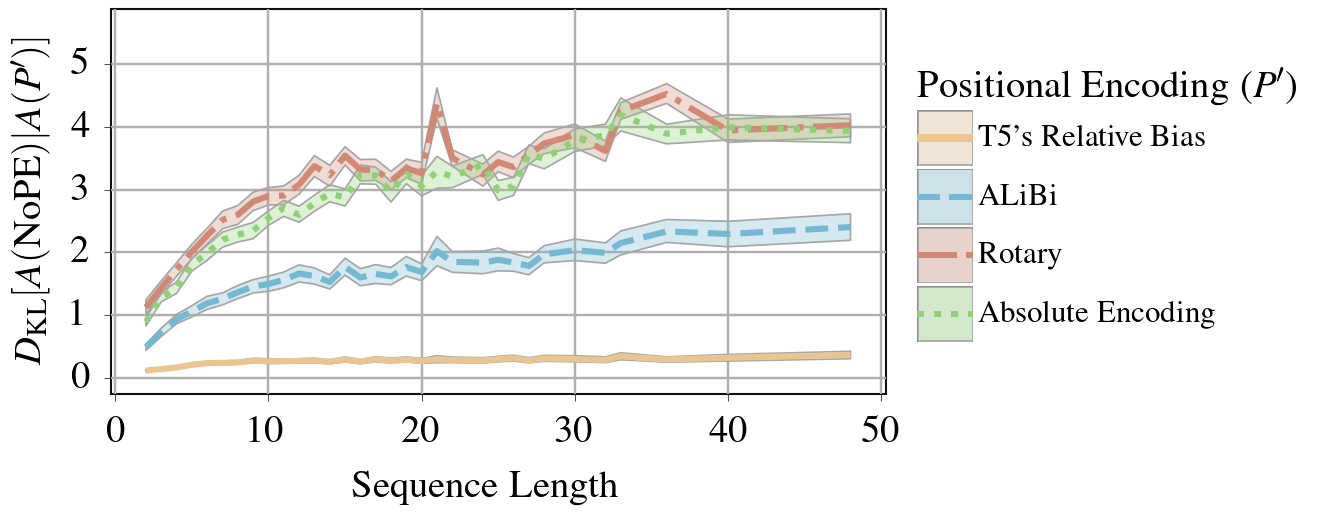

<ggplot: (8778740723444)>

In [14]:
import plotnine as p9

pdf = opdf
pdf = pdf[(pdf["seq_length"] != -1) & (pdf["kl"].isnull() == False)]
pdf["scratchpad_config"] = pdf.apply(
    wandb_utils.df_prettify_scratchpad_config_name, axis=1
)

existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [
    pe
    for pe in wandb_utils.get_pretty_scratchpad_config_order()
    if pe in existing_configs
]
print(config_order)
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

# Fix pe names
def fix_nope_name(pe_name):
#     if pe_name.lower() == "no pe":
#         return "No Position Encoding"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Encoding"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["T5's Relative Bias", "ALiBi", "Rotary", "Absolute Encoding"]
)

pdf["new_pe"] = pdf["pe"].str[:2]
pdf["new_pe"] = pdf["new_pe"].astype("category")
pdf["new_pe"] = pdf["new_pe"].cat.reorder_categories(
    ["T5", "AL", "Ro", "Ab"]
)


p9u = importlib.reload(p9u)

# pdf = pdf[pdf["seq_length"] % 4 == 0]

p = (
    p9.ggplot(pdf, p9.aes(x="seq_length", y="kl"))
#     + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.05, fill="#6e006e")
    + p9.geom_ribbon(
        p9.aes(ymin=p9.after_stat("ymin"), ymax=p9.after_stat("ymax"), fill="pe"),
        alpha=0.3,
        color="#A6A6A6",
        size=0.7,
        outline_type="full",
        stat="summary",
#         stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 0.5}),
    )
    + p9.geom_line(
        mapping=p9.aes(fill="pe", color="pe", linetype="pe"),
        size=2.5,
        # stat=p9.stat_summary(fun_data="mean_sdl", geom="geom_line")
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
        #             stat=p9.stat_summary(mapping=p9.aes(y="output_acc"), geom="geom_line")
    )
#     + p9.geom_point(
#         mapping=p9.aes(
#             fill="pe",
# #             shape="pe",
#         ),
#         size=6.5,
#         color="#000",
#         stroke=0.5,
#         stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
#     )
#     + p9.annotate("text", x=12, y=5.5, label="I.I.D")
#     + p9.facet_wrap("scratchpad_config", ncol=3)
#     + p9.scale_x_continuous(limits=[8, 48])
    + p9.scale_y_continuous(breaks=np.arange(0, 8, 1))
    + p9.labs(
        x="Sequence Length",
        y=r"$D_\mathrm{KL}[A(\mathrm{NoPE}) | A({P^\prime})]$",
        color=r"Positional Encoding ($P^\prime$)",
        fill="Positional Encoding ($P^\prime$)",
        shape="Positional Encoding ($P^\prime$)",
        linetype="Positional Encoding ($P^\prime$)",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
#     + p9.theme_minimal()
    + p9u.scale_fill_prism("formal_shifted")
    + p9u.scale_color_prism("formal_shifted")
    + p9u.theme_formal(
        grid="YX",
         base_size=28, axis_text_size=28, strip_text_size=28
    )
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
        figure_size=(10, 5),
    )
)
# p.save(output_dir / f"avg_all_layers__{DATASET}__{SPLIT}.pdf")
p

['No Scratchpad']
['ALiBi' 'Absolute Sinusoid' 'No PE' 'Rotary' "T5's Relative Bias"]
['ALiBi' 'APE' "NoPE'" 'Rotary' "T5's RPE"]


/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 7 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/final_kl_ind/avg_all_layers__scan__mdlen_tr25_ts48_paper.pdf


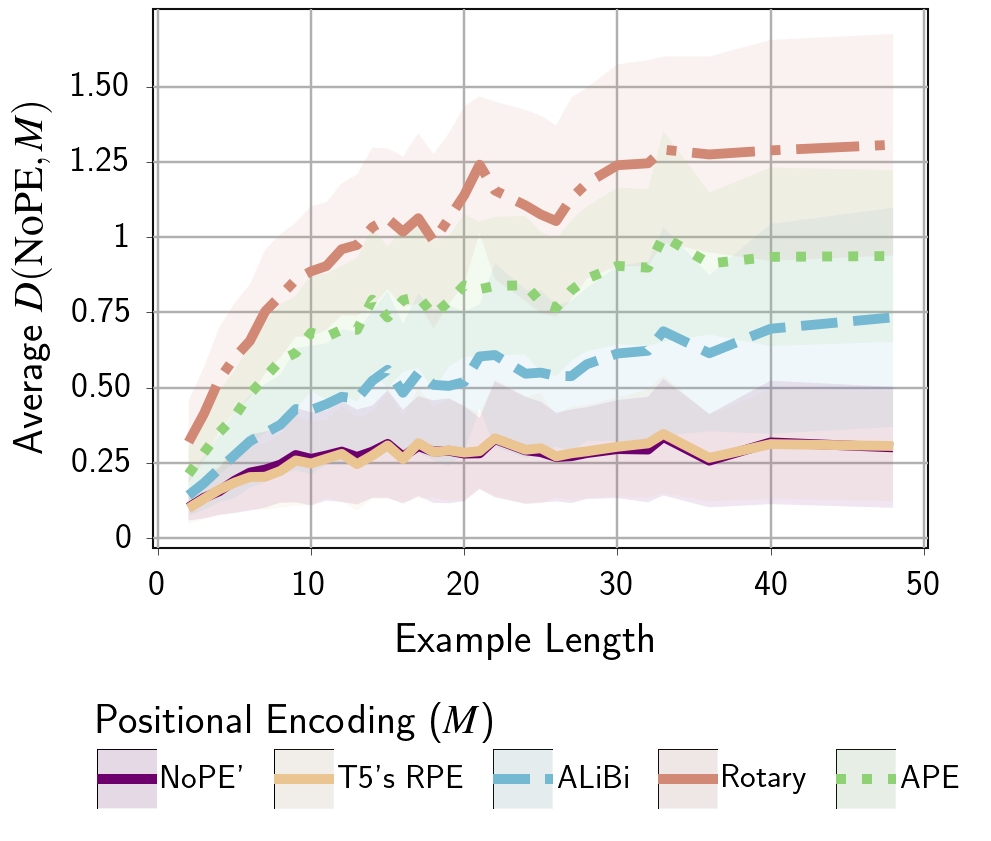

<ggplot: (8769528457738)>

In [106]:
import plotnine as p9

metric = "jsd"

pdf = opdf_jsd_min.copy()
# pdf = opdf_jsd_mean.copy()
pdf = pdf[(pdf["seq_length"] != -1) & (pdf[metric].isnull() == False)]
pdf["scratchpad_config"] = pdf.apply(
    wandb_utils.df_prettify_scratchpad_config_name, axis=1
)

existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [
    pe
    for pe in wandb_utils.get_pretty_scratchpad_config_order()
    if pe in existing_configs
]
print(config_order)
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

# Fix pe names
def fix_nope_name(pe_name):
#     if pe_name.lower() == "no pe":
#         return "No Position Encoding"
    if "absolute" in pe_name.lower():
        return "APE"
    if "T5" in pe_name:
        return "T5's RPE"
    if "No PE" in pe_name:
        return r"NoPE'"

    return pe_name
print(pdf["pe"].unique())
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)
print(pdf["pe"].unique())
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    [r"NoPE'", "T5's RPE", "ALiBi", "Rotary", "APE"]
)

# pdf["new_pe"] = pdf["pe"].str[:2]
# pdf["new_pe"] = pdf["new_pe"].astype("category")
# pdf["new_pe"] = pdf["new_pe"].cat.reorder_categories(
#     ["T5", "AL", "Ro", "Ab"]
# )


p9u = importlib.reload(p9u)

# pdf = pdf[pdf["seq_length"] % 4 == 0]

p = (
    p9.ggplot(pdf, p9.aes(x="seq_length", y=metric))
#     + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.05, fill="#6e006e")
    + p9.geom_ribbon(
        p9.aes(ymin=p9.after_stat("ymin"), ymax=p9.after_stat("ymax"), fill="pe"),
        alpha=0.1,
#         color="#A6A6A6",
#         size=0.7,
#         outline_type="full",
#         stat="summary",
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.geom_line(
        mapping=p9.aes(fill="pe", color="pe", linetype="pe"),
        size=4,
        # stat=p9.stat_summary(fun_data="mean_sdl", geom="geom_line")
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
        #             stat=p9.stat_summary(mapping=p9.aes(y="output_acc"), geom="geom_line")
    )
    + p9.scale_linetype_manual(values=['solid', 'solid','dashed','dashdot','dotted'])
    + p9.scale_y_continuous(breaks=np.arange(0, 1.7, 0.25))
    + p9.labs(
        x="Example Length",
        y=r"Average $D(\mathrm{NoPE}, M)$",
        color=r"Positional Encoding ($M$)",
        fill="Positional Encoding ($M$)",
        shape="Positional Encoding ($M$)",
        linetype="Positional Encoding ($M$)",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
#     + p9.theme_minimal()
    + p9u.scale_fill_prism("formal")
    + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="YX",
         
        base_size=30, axis_text_size=26,
        strip_text_size=20,
    )
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        legend_position="bottom",
        legend_box_spacing=1.2,
        legend_entry_spacing=20,
        # legend_box="vertical",
        figure_size=(10, 7),
    )
)
p.save(output_dir / f"avg_all_layers__{DATASET}__{SPLIT}_paper.pdf")
p

['No Scratchpad']
['ALiBi' 'Absolute Sinusoid' 'No PE' 'Rotary' "T5's Relative Bias"]
['ALiBi' 'APE' "NoPE'" 'Rotary' "T5's RPE"]


/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 6.25 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/final_kl_ind/avg_all_layers_noleg__scan__mdlen_tr25_ts48_paper.pdf


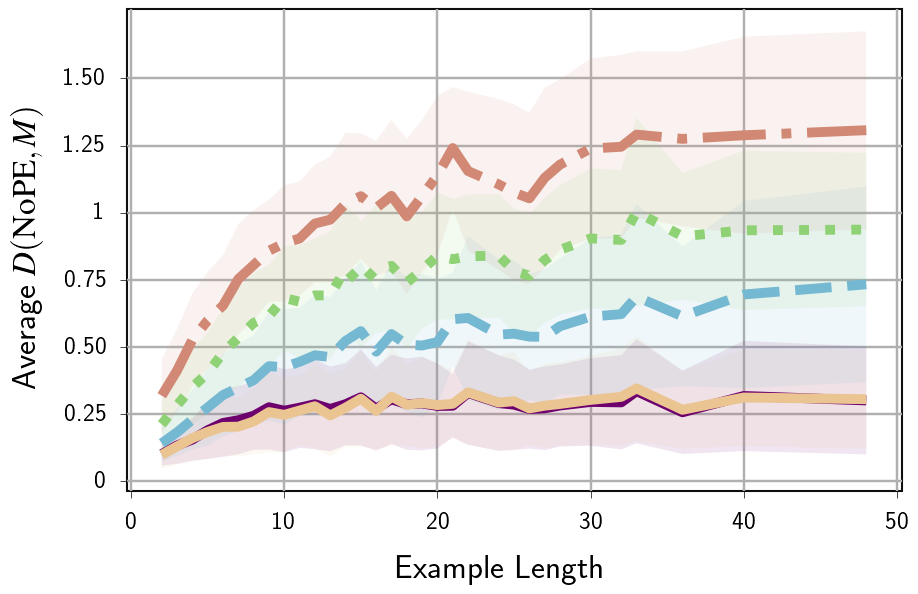

<ggplot: (8766175964040)>

In [43]:
import plotnine as p9

metric = "jsd"

pdf = opdf_jsd_min.copy()
# pdf = opdf_jsd_mean.copy()
pdf = pdf[(pdf["seq_length"] != -1) & (pdf[metric].isnull() == False)]
pdf["scratchpad_config"] = pdf.apply(
    wandb_utils.df_prettify_scratchpad_config_name, axis=1
)

existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [
    pe
    for pe in wandb_utils.get_pretty_scratchpad_config_order()
    if pe in existing_configs
]
print(config_order)
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

# Fix pe names
def fix_nope_name(pe_name):
#     if pe_name.lower() == "no pe":
#         return "No Position Encoding"
    if "absolute" in pe_name.lower():
        return "APE"
    if "T5" in pe_name:
        return "T5's RPE"
    if "No PE" in pe_name:
        return r"NoPE'"

    return pe_name
print(pdf["pe"].unique())
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)
print(pdf["pe"].unique())
pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    [r"NoPE'", "T5's RPE", "ALiBi", "Rotary", "APE"]
)

# pdf["new_pe"] = pdf["pe"].str[:2]
# pdf["new_pe"] = pdf["new_pe"].astype("category")
# pdf["new_pe"] = pdf["new_pe"].cat.reorder_categories(
#     ["T5", "AL", "Ro", "Ab"]
# )


# pdf = pdf[pdf["pe"] != "NoPE"]

p9u = importlib.reload(p9u)

# pdf = pdf[pdf["seq_length"] % 4 == 0]

p = (
    p9.ggplot(pdf, p9.aes(x="seq_length", y=metric))
#     + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.05, fill="#6e006e")
    + p9.geom_ribbon(
        p9.aes(ymin=p9.after_stat("ymin"), ymax=p9.after_stat("ymax"), fill="pe"),
        alpha=0.1,
#         color="#A6A6A6",
#         size=0.7,
#         outline_type="full",
#         stat="summary",
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.geom_line(
        mapping=p9.aes(fill="pe", color="pe", linetype="pe"),
        size=4,
        # stat=p9.stat_summary(fun_data="mean_sdl", geom="geom_line")
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
        #             stat=p9.stat_summary(mapping=p9.aes(y="output_acc"), geom="geom_line")
    )
    + p9.scale_linetype_manual(values=['solid', 'solid','dashed','dashdot','dotted'])
    + p9.scale_y_continuous(breaks=np.arange(0, 1.7, 0.25))
    + p9.labs(
        x="Example Length",
        y=r"Average $D(\mathrm{NoPE}, M)$",
        color=r"Positional Encoding ($M$)",
        fill="Positional Encoding ($M$)",
        shape="Positional Encoding ($M$)",
        linetype="Positional Encoding ($M$)",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
#     + p9.theme_minimal()
    + p9u.scale_fill_prism("formal")
    + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="YX",
        base_size=24, axis_text_size=18,
    )
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        legend_position="none",
        legend_box_spacing=1.2,
        legend_entry_spacing=20,
        # legend_box="vertical",
        figure_size=(10, 6.25),
    )
)
p.save(output_dir / f"avg_all_layers_noleg__{DATASET}__{SPLIT}_paper.pdf")
p

### Per layer

['No Scratchpad']


/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 20 x 10 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/final_kl_ind/per_layer__scan__mdlen_tr25_ts48.pdf


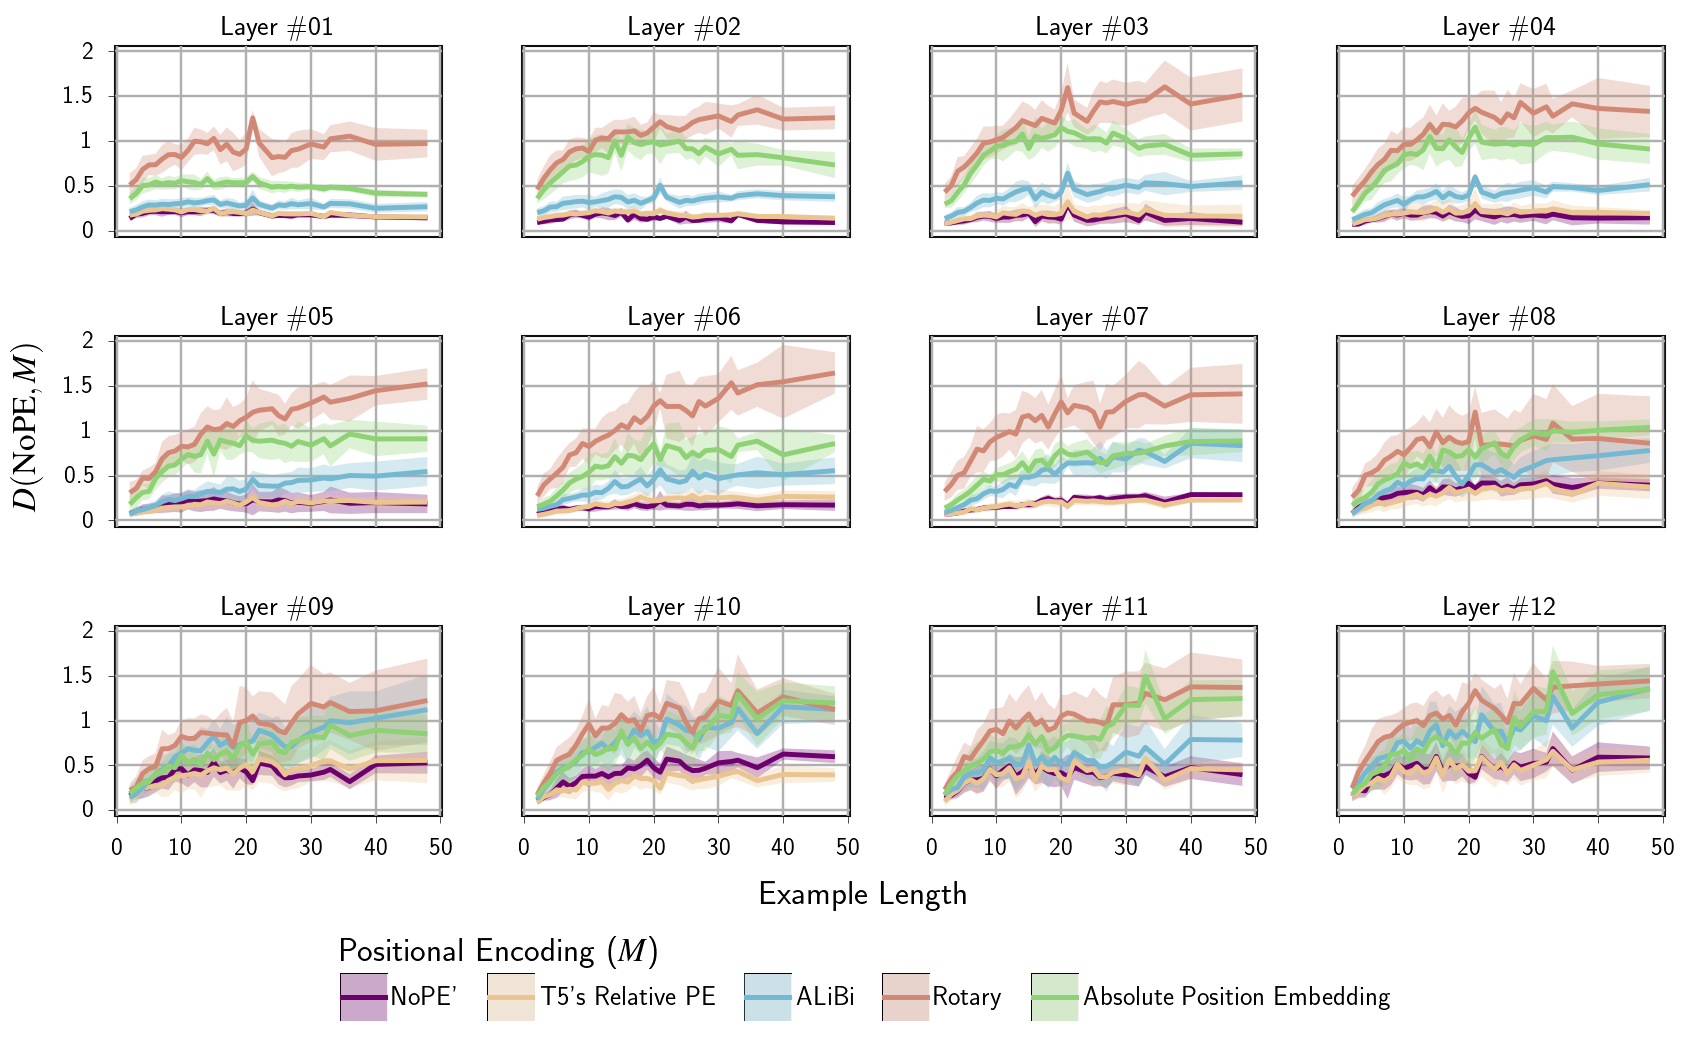

<ggplot: (8769330710956)>

In [104]:
import plotnine as p9

metric = "jsd"

pdf = opdf_jsd_min.copy()
# pdf = opdf_jsd_mean.copy()
pdf = pdf[(pdf["seq_length"] != -1) & (pdf[metric].isnull() == False)]
pdf["scratchpad_config"] = pdf.apply(
    wandb_utils.df_prettify_scratchpad_config_name, axis=1
)

existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [
    pe
    for pe in wandb_utils.get_pretty_scratchpad_config_order()
    if pe in existing_configs
]
print(config_order)
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)


# Fix pe names
def fix_nope_name(pe_name):
#     if pe_name.lower() == "no pe":
#         return "No Position Encoding"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Position Embedding"
    if "T5" in pe_name:
        return "T5's Relative PE"
    if "No PE" in pe_name:
        return "NoPE'"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["NoPE'", "T5's Relative PE", "ALiBi", "Rotary", "Absolute Position Embedding"]
)

pdf["new_pe"] = pdf["pe"].str[:2]
pdf["new_pe"] = pdf["new_pe"].astype("category")
pdf["new_pe"] = pdf["new_pe"].cat.reorder_categories(
    ["No", "T5", "AL", "Ro", "Ab"]
)

def fix_layer_name(layer_idx):
    return r"Layer \#"+f"{str(int(layer_idx+1)).zfill(2)}"

pdf["layer_idx_pretty"] = pdf["layer_idx"].apply(fix_layer_name)

p9u = importlib.reload(p9u)


p = (
    p9.ggplot(pdf, p9.aes(x="seq_length", y=metric))
#     + p9.geom_point(
#         mapping=p9.aes(
#             fill="pe",
#             shape="pe",
#         ),
#         size=3.0,
#         stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
#         alpha=0.6,
#     )
    + p9.geom_ribbon(
        p9.aes(ymin=p9.after_stat("ymin"), ymax=p9.after_stat("ymax"), fill="pe"),
        alpha=0.3,
#         stat="summary",
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.geom_line(
        mapping=p9.aes(fill="pe", color="pe"),
        size=2,
        # stat=p9.stat_summary(fun_data="mean_sdl", geom="geom_line")
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
        #             stat=p9.stat_summary(mapping=p9.aes(y="output_acc"), geom="geom_line")
    )
#     + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.05, fill="gray")
#     + p9.annotate("text", x=12, y=5.5, label="I.I.D")
    + p9.facet_wrap("layer_idx_pretty", ncol=4)
#     + p9.scale_x_continuous(breaks=np.arange(7, 17), limits=[7, 14])
    + p9.labs(
        x="Example Length",
        y=r"$D(\mathrm{No PE}, M)$",
        color=r"Positional Encoding ($M$)",
        fill="Positional Encoding ($M$)",
        shape="Positional Encoding ($M$)",
        linetype="Positional Encoding ($M$)",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
#     + p9.theme_minimal()
    + p9u.scale_fill_prism("formal")
    + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="YX",
        base_size=24, axis_text_size=18,
    )
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
        strip_text_x=p9.element_text(size=20),
        strip_margin_y=0,
        panel_spacing_x=0.8,
        panel_spacing_y=0.55,
        legend_position="bottom",
        legend_box_spacing=0.9,
        legend_entry_spacing=20,
#         panel_grid_major=p9.element_line(size=1.5),
#         panel_border=p9.element_rect(fill="None", color="#0F0F0F", size=1),
        figure_size=(20, 10),
    )
)
p.save(output_dir / f"per_layer__{DATASET}__{SPLIT}.pdf")
p

['No Scratchpad']


/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 20 x 2.5 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/final_kl_ind/per_layer_4__scan__mdlen_tr25_ts48.pdf


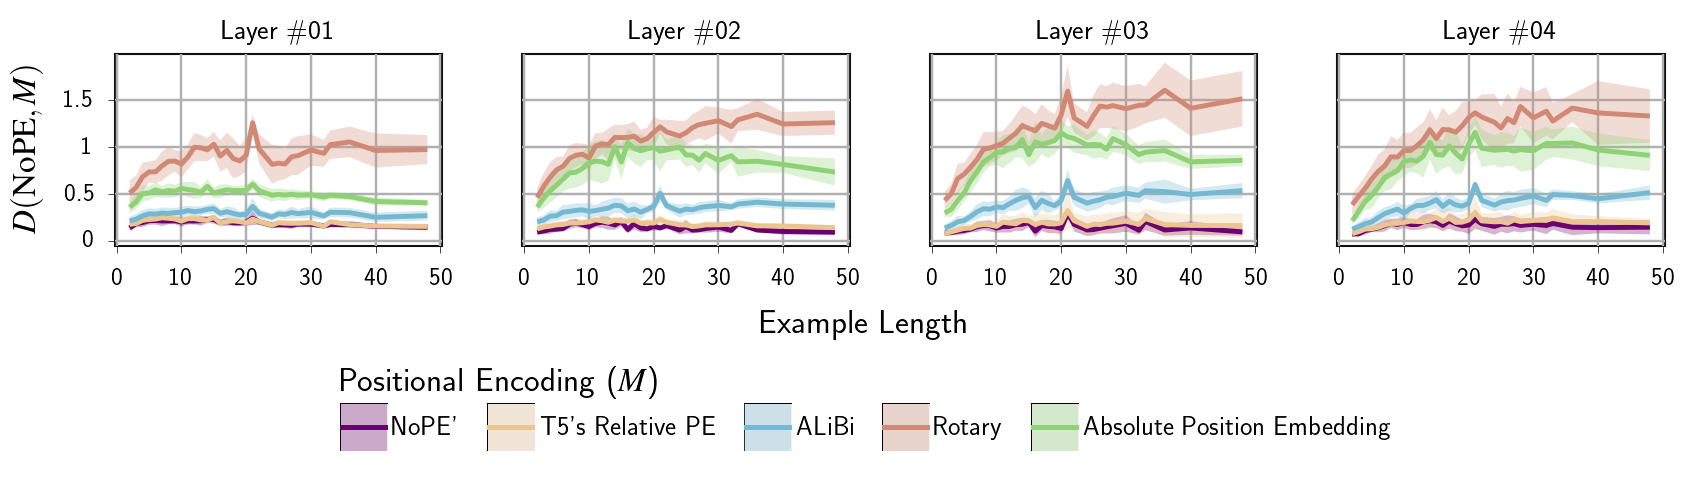

<ggplot: (8766176779424)>

In [27]:
import plotnine as p9

metric = "jsd"

pdf = opdf_jsd_min.copy()
# pdf = opdf_jsd_mean.copy()
pdf = pdf[(pdf["seq_length"] != -1) & (pdf[metric].isnull() == False)]
pdf["scratchpad_config"] = pdf.apply(
    wandb_utils.df_prettify_scratchpad_config_name, axis=1
)

existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [
    pe
    for pe in wandb_utils.get_pretty_scratchpad_config_order()
    if pe in existing_configs
]
print(config_order)
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)


# Fix pe names
def fix_nope_name(pe_name):
#     if pe_name.lower() == "no pe":
#         return "No Position Encoding"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Position Embedding"
    if "T5" in pe_name:
        return "T5's Relative PE"
    if "No PE" in pe_name:
        return "NoPE'"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["NoPE'", "T5's Relative PE", "ALiBi", "Rotary", "Absolute Position Embedding"]
)

pdf["new_pe"] = pdf["pe"].str[:2]
pdf["new_pe"] = pdf["new_pe"].astype("category")
pdf["new_pe"] = pdf["new_pe"].cat.reorder_categories(
    ["No", "T5", "AL", "Ro", "Ab"]
)

pdf = pdf[pdf["layer_idx"] <= 3]

def fix_layer_name(layer_idx):
    return r"Layer \#"+f"{str(int(layer_idx+1)).zfill(2)}"

pdf["layer_idx_pretty"] = pdf["layer_idx"].apply(fix_layer_name)

p9u = importlib.reload(p9u)


p = (
    p9.ggplot(pdf, p9.aes(x="seq_length", y=metric))
#     + p9.geom_point(
#         mapping=p9.aes(
#             fill="pe",
#             shape="pe",
#         ),
#         size=3.0,
#         stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
#         alpha=0.6,
#     )
    + p9.geom_ribbon(
        p9.aes(ymin=p9.after_stat("ymin"), ymax=p9.after_stat("ymax"), fill="pe"),
        alpha=0.3,
#         stat="summary",
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.geom_line(
        mapping=p9.aes(fill="pe", color="pe"),
        size=2,
        # stat=p9.stat_summary(fun_data="mean_sdl", geom="geom_line")
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
        #             stat=p9.stat_summary(mapping=p9.aes(y="output_acc"), geom="geom_line")
    )
#     + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.05, fill="gray")
#     + p9.annotate("text", x=12, y=5.5, label="I.I.D")
    + p9.facet_wrap("layer_idx_pretty", ncol=4)
#     + p9.scale_x_continuous(breaks=np.arange(7, 17), limits=[7, 14])
    + p9.labs(
        x="Example Length",
        y=r"$D(\mathrm{No PE}, M)$",
        color=r"Positional Encoding ($M$)",
        fill="Positional Encoding ($M$)",
        shape="Positional Encoding ($M$)",
        linetype="Positional Encoding ($M$)",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
#     + p9.theme_minimal()
    + p9u.scale_fill_prism("formal")
    + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="YX",
        base_size=24, axis_text_size=18,
    )
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
        strip_text_x=p9.element_text(size=20),
        strip_margin_y=0,
        panel_spacing_x=0.8,
        panel_spacing_y=0.55,
        legend_position="bottom",
        legend_box_spacing=0.9,
        legend_entry_spacing=20,
#         panel_grid_major=p9.element_line(size=1.5),
#         panel_border=p9.element_rect(fill="None", color="#0F0F0F", size=1),
        figure_size=(20, 2.5),
    )
)
p.save(output_dir / f"per_layer_4__{DATASET}__{SPLIT}.pdf")
p

['No Scratchpad']


/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 6 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/final_kl_ind/per_layer_2x2__scan__mdlen_tr25_ts48.pdf


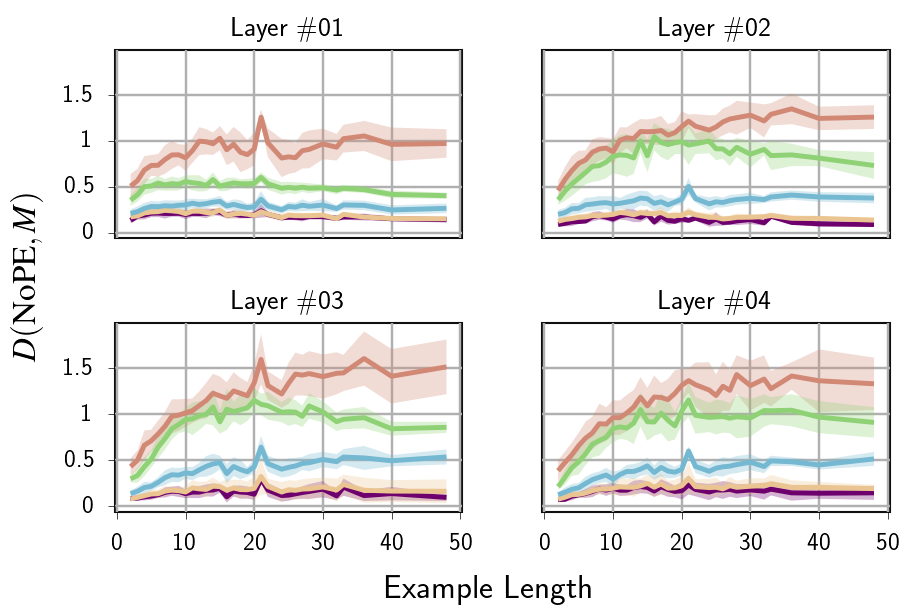

<ggplot: (8766173279079)>

In [36]:
import plotnine as p9

metric = "jsd"

pdf = opdf_jsd_min.copy()
# pdf = opdf_jsd_mean.copy()
pdf = pdf[(pdf["seq_length"] != -1) & (pdf[metric].isnull() == False)]
pdf["scratchpad_config"] = pdf.apply(
    wandb_utils.df_prettify_scratchpad_config_name, axis=1
)

existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [
    pe
    for pe in wandb_utils.get_pretty_scratchpad_config_order()
    if pe in existing_configs
]
print(config_order)
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)


# Fix pe names
def fix_nope_name(pe_name):
#     if pe_name.lower() == "no pe":
#         return "No Position Encoding"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Position Embedding"
    if "T5" in pe_name:
        return "T5's Relative PE"
    if "No PE" in pe_name:
        return "NoPE'"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["NoPE'", "T5's Relative PE", "ALiBi", "Rotary", "Absolute Position Embedding"]
)

pdf["new_pe"] = pdf["pe"].str[:2]
pdf["new_pe"] = pdf["new_pe"].astype("category")
pdf["new_pe"] = pdf["new_pe"].cat.reorder_categories(
    ["No", "T5", "AL", "Ro", "Ab"]
)

pdf = pdf[pdf["layer_idx"] <= 3]

def fix_layer_name(layer_idx):
    return r"Layer \#"+f"{str(int(layer_idx+1)).zfill(2)}"

pdf["layer_idx_pretty"] = pdf["layer_idx"].apply(fix_layer_name)

p9u = importlib.reload(p9u)


p = (
    p9.ggplot(pdf, p9.aes(x="seq_length", y=metric))
#     + p9.geom_point(
#         mapping=p9.aes(
#             fill="pe",
#             shape="pe",
#         ),
#         size=3.0,
#         stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
#         alpha=0.6,
#     )
    + p9.geom_ribbon(
        p9.aes(ymin=p9.after_stat("ymin"), ymax=p9.after_stat("ymax"), fill="pe"),
        alpha=0.3,
#         stat="summary",
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.geom_line(
        mapping=p9.aes(fill="pe", color="pe"),
        size=2,
        # stat=p9.stat_summary(fun_data="mean_sdl", geom="geom_line")
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
        #             stat=p9.stat_summary(mapping=p9.aes(y="output_acc"), geom="geom_line")
    )
#     + p9.annotate("rect", xmin=0, xmax=25, ymin=0, ymax=6, alpha=0.05, fill="gray")
#     + p9.annotate("text", x=12, y=5.5, label="I.I.D")
    + p9.facet_wrap("layer_idx_pretty", ncol=2)
#     + p9.scale_x_continuous(breaks=np.arange(7, 17), limits=[7, 14])
    + p9.labs(
        x="Example Length",
        y=r"$D(\mathrm{No PE}, M)$",
        color=r"Positional Encoding ($M$)",
        fill="Positional Encoding ($M$)",
        shape="Positional Encoding ($M$)",
        linetype="Positional Encoding ($M$)",
    )
    # + p9u.scale_fill_prism("FB_bellsprout2")
    # + p9u.scale_color_prism("FB_bellsprout2")
#     + p9.theme_minimal()
    + p9u.scale_fill_prism("formal")
    + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="YX",
        base_size=24, axis_text_size=18,
    )
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
        # legend_box_spacing=0.20,
        # legend_position="bottom",
        # legend_box="vertical",
        strip_text_x=p9.element_text(size=20),
        strip_margin_y=0,
        panel_spacing_x=0.8,
        panel_spacing_y=0.4,
        legend_position="none",
        legend_box_spacing=0.9,
        legend_entry_spacing=20,
#         panel_grid_major=p9.element_line(size=1.5),
#         panel_border=p9.element_rect(fill="None", color="#0F0F0F", size=1),
        figure_size=(10, 6),
    )
)
p.save(output_dir / f"per_layer_2x2__{DATASET}__{SPLIT}.pdf")
p